In [528]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
import joblib

import warnings
warnings.filterwarnings("ignore")

In [529]:
data = pd.read_csv('../Datasets/diabetes_prediction_dataset.csv')

In [530]:
data['gender'] = data['gender'].astype(str).str.strip().str.upper()

In [531]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [532]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

In [533]:
# Configuración de submuestreo estratificado
total_samples = 100000  # Cambia este valor: 1000, 5000, 10000, 50000, 100000

# Calcular muestras por clase manteniendo proporciones 91.5% / 8.5%
class_0_samples = int(total_samples * 0.915)
class_1_samples = int(total_samples * 0.085)

print(f"=== CONFIGURACIÓN: {total_samples} muestras totales ===")
print(f"Clase 0 (No diabetes): {class_0_samples}")
print(f"Clase 1 (Diabetes): {class_1_samples}")

# Submuestreo estratificado
stratified_data = pd.concat([
    data[data['diabetes'] == 0].sample(n=min(class_0_samples, len(data[data['diabetes'] == 0])), random_state=42),
    data[data['diabetes'] == 1].sample(n=min(class_1_samples, len(data[data['diabetes'] == 1])), random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nDistribución final:")
print(stratified_data['diabetes'].value_counts())
print(f"Proporciones finales:")
print(stratified_data['diabetes'].value_counts(normalize=True))

# Actualizar los datos para el resto del pipeline
data = stratified_data

=== CONFIGURACIÓN: 100000 muestras totales ===
Clase 0 (No diabetes): 91500
Clase 1 (Diabetes): 8500

Distribución final:
diabetes
0    91500
1     8500
Name: count, dtype: int64
Proporciones finales:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [534]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [535]:
# Calcular pesos automáticamente
class_counts = Counter(y)
print(f"Conteo de clases: {class_counts}")

total_samples = len(y)
weight_for_0 = total_samples / class_counts[0] 
weight_for_1 = total_samples / class_counts[1]

# En XGBoost, scale_pos_weight es el ratio
scale_pos_weight = weight_for_1 / weight_for_0
print(f"Scale pos weight calculado: {scale_pos_weight}")

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight))])

Conteo de clases: Counter({0: 91500, 1: 8500})
Scale pos weight calculado: 10.76470588235294


In [536]:
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [3],
    'classifier__learning_rate': [0.001, 0.01],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8]
}

In [537]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


In [538]:
model_dir = f'../Guardar_modelo/ML/Binary/'
os.makedirs(model_dir, exist_ok=True)

model_path = f'{model_dir}Binary_{total_samples}_xgboost.pkl'
joblib.dump(grid_search.best_estimator_, model_path) 

['../Guardar_modelo/ML/Binary/Binary_100000_xgboost.pkl']

Model Accuracy:  0.94695
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18312
           1       0.65      0.80      0.72      1688

    accuracy                           0.95     20000
   macro avg       0.82      0.88      0.84     20000
weighted avg       0.95      0.95      0.95     20000



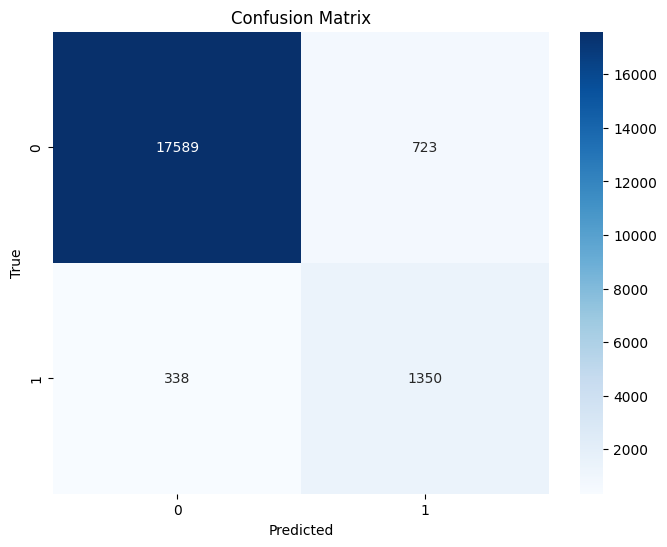

In [539]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()